<a href="https://colab.research.google.com/github/SeenaKhosravi/NASS/blob/main/NASS_Analysis_Notebookconsoledump040125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

# Abstract

# Setup and Load Data

In [2]:
# Install required Python libraries
!pip install rpy2 matplotlib pandas

# Load rpy2 to run R code in the notebook
%load_ext rpy2.ipython

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%R

# Define required packages
required_packages <- c("data.table", "dplyr", "survey", "tidyverse", "tidycensus",
"ggplot2", "gridExtra","caret", "randomForest", "pROC", "broom", "lme4",
"gtsummary", "corrplot")

# Function to check and install missing packages
install_if_missing <- function(packages) {
  new_packages <- packages[!(packages %in% installed.packages()[,"Package"])]
  if(length(new_packages)) install.packages(new_packages)
}

# Function to load all required libraries
load_libraries <- function(packages) {
  lapply(packages, library, character.only = TRUE)
}

# Check and install missing packages, then load packages
install_if_missing(required_packages)
load_libraries(required_packages)
rm(required_packages, install_if_missing, load_libraries)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ tidyr::expand()      masks Matrix::expand()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ tidyr::pack()        masks Matrix::pack()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purr

data.table 1.17.0 using 4 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

The following object is masked from ‘package:survival’:

    cluster

randomForest 4.7-1.2
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is

In [5]:
%%R

#Load NASS 2020 dataset

# 1. Check if file exists:
file_path <- "/content/drive/My Drive/NASS_2020_all.csv"
if (file.exists(file_path)) {
  print("File found!")
} else {
  stop("File not found. Exiting.")
}

# 2. Attempt to load using fread:
NASS_2020_all <- fread(file_path)

# 3. Verify data structure:
str(NASS_2020_all)
colnames(NASS_2020_all)

[1] "File found!"
Classes ‘data.table’ and 'data.frame':	7828310 obs. of  675 variables:
 $ KEY_NASS           : int  10000001 10000002 10000003 10000004 10000005 10000006 10000007 10000008 10000009 10000010 ...
 $ HOSP_NASS          : int  10446 10031 10145 10143 10326 10295 10202 10092 10357 10402 ...
 $ HOSP_TEACH         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ HOSP_LOCATION      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ HOSP_LOCTEACH      : int  3 3 3 3 3 3 3 3 3 3 ...
 $ HOSP_REGION        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ HOSP_BEDSIZE_CAT   : int  1 3 3 3 3 3 3 3 2 2 ...
 $ DISCWT             : num  1.27 1.29 1.29 1.14 1.14 ...
 $ NASS_STRATUM       : int  40 58 58 33 33 58 33 33 40 40 ...
 $ N_DISC_U           : int  325943 381183 381183 658010 658010 381183 658010 658010 325943 325943 ...
 $ N_HOSP_U           : int  137 100 100 75 75 100 75 75 137 137 ...
 $ S_DISC_U           : int  256022 295908 295908 574998 574998 295908 574998 574998 256022 256022 ...
 $ S_HOSP_U           : int  105 7

|--------------------------------------------------|
|==================================================|
|--------------------------------------------------|
|==================================================|


# Dataset Overview

Exception ignored from cffi callback <function _processevents at 0x78f0375f65c0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 


In addition: Warning message:
In cor(NASS_2020_all[, 1:28], use = "complete.obs") :
  the standard deviation is zero


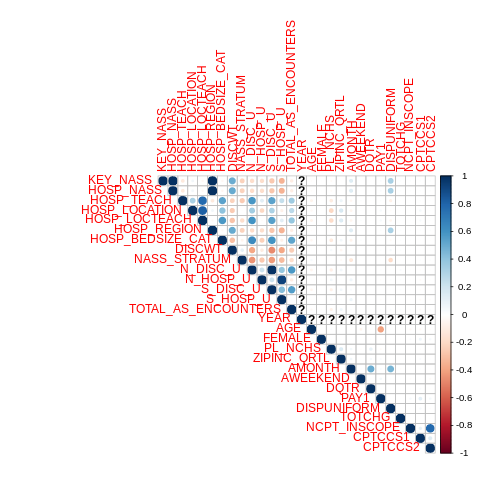

In [7]:
%%R

# Load necessary libraries
if (!requireNamespace("gtsummary", quietly = TRUE)) install.packages("gtsummary")
if (!requireNamespace("corrplot", quietly = TRUE)) install.packages("corrplot")
library(gtsummary)
library(corrplot)


# Output 1a: Summary of Dataset
NASS_2020_all[,1:28] %>% tbl_summary()

# Output 1b: Correlation matrix and plot
res <- cor(NASS_2020_all[,1:28], use = "complete.obs")
corrplot(res, type = "upper")


# Institutional Overview

# Encounter Overview

# Census Benchmarking

In [55]:
%%R

YOUR_CENSUS_API_KEY <- "15ba7b551d88c516b5c63752d2612d19f045bfea"  # Replace with your actual Census API key

library(tidycensus)

##########################
# Setup
##########################

# Set up your Census API key
census_api_key("15ba7b551d88c516b5c63752d2612d19f045bfea", install = TRUE)

# List of states included in NASS_2020_all
states_in_nass <- c("Alaska", "California", "Colorado", "Connecticut", "District of Columbia", "Florida", "Georgia", "Hawaii", "Iowa",
                    "Illinois", "Indiana", "Kansas", "Kentucky", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "North Carolina",
                    "North Dakota", "Nebraska", "New Jersey", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "South Carolina",
                    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Wisconsin")

# Import data for total population by state by age from the 2020 Census
# U.S. Census Bureau, U.S. Department of Commerce.
# 2020 Decennial Census, DHC-A

# Define a function to construct population variables and labels based on the desired base variable
# Base variable P12 for total, P12I for white alone, not Hispanic or Latino
# See https://api.census.gov/data/2020/dec/dhc/groups.html for available groups

# Define a function to construct population variables and labels based on the desired base variable
get_population_variables <- function(base_variable) {
  variables <- paste0(base_variable, "_", sprintf("%03dN", 1:49))

  labels <- c(
    "Total",
    "Male: Total",
    "Male: Under 5 years",
    "Male: 5 to 9 years",
    "Male: 10 to 14 years",
    "Male: 15 to 17 years",
    "Male: 18 and 19 years",
    "Male: 20 years",
    "Male: 21 years",
    "Male: 22 to 24 years",
    "Male: 25 to 29 years",
    "Male: 30 to 34 years",
    "Male: 35 to 39 years",
    "Male: 40 to 44 years",
    "Male: 45 to 49 years",
    "Male: 50 to 54 years",
    "Male: 55 to 59 years",
    "Male: 60 and 61 years",
    "Male: 62 to 64 years",
    "Male: 65 and 66 years",
    "Male: 67 to 69 years",
    "Male: 70 to 74 years",
    "Male: 75 to 79 years",
    "Male: 80 to 84 years",
    "Male: 85 years and over",
    "Female: Total",
    "Female: Under 5 years",
    "Female: 5 to 9 years",
    "Female: 10 to 14 years",
    "Female: 15 to 17 years",
    "Female: 18 and 19 years",
    "Female: 20 years",
    "Female: 21 years",
    "Female: 22 to 24 years",
    "Female: 25 to 29 years",
    "Female: 30 to 34 years",
    "Female: 35 to 39 years",
    "Female: 40 to 44 years",
    "Female: 45 to 49 years",
    "Female: 50 to 54 years",
    "Female: 55 to 59 years",
    "Female: 60 and 61 years",
    "Female: 62 to 64 years",
    "Female: 65 and 66 years",
    "Female: 67 to 69 years",
    "Female: 70 to 74 years",
    "Female: 75 to 79 years",
    "Female: 80 to 84 years",
    "Female: 85 years and over"
  )

  names(labels) <- variables
  labels <- as.character(labels)

  return(list(variables = variables, labels = labels))
}

# Function to get population data by state, age, and gender from the 2020 Census DHC file
get_population_data <- function(variables, labels) {
  population_data <- get_decennial(
    geography = "state",
    variables = variables,
    year = 2020,
    sumfile = "dhc"
  )

  # Replace variable codes with labels
  population_data <- population_data %>%
    mutate(variable = recode(variable, !!!setNames(labels, variables)))

  # Reshape the data for better analysis
  population_data <- population_data %>%
    pivot_wider(names_from = variable, values_from = value)

  return(population_data)
}

# Make total all vars for query
population_info <- get_population_variables("P12")

# Get the total population data by state, age, and gender
total_population_by_age_gender <- get_population_data(population_info$variables, population_info$labels)

# Make total white alone vars for query
population_info_w <- get_population_variables("P12I")

# Get the total population data by state, age, and gender
total_population_by_age_gender_white <- get_population_data(population_info_w$variables, population_info_w$labels)

########################################
# Stage 1a
# Unadjusted proportion of White individuals in the NASS 2020 data
# Reference value for White Only, (Not Hispanic or Latino) proportion for the whole US from the 2020 US Census
########################################

# Create a dummy variable WHITE which is 1 when RACE = 1, and 0 otherwise
NASS_2020_all[, WHITE := ifelse(RACE == 1, 1, 0)]
NASS_2020_all <- NASS_2020_all[, c(1:28, 108, 674:675)]

# Calculate the unadjusted proportion of WHITE
unadjusted_proportion_white <- mean(NASS_2020_all$WHITE)
print(paste("Unadjusted proportion of WHITE:", unadjusted_proportion_white))

# Reference value for White Only proportion for the whole US from the 2020 US Census
us_census_white_proportion <- sum(total_population_by_age_gender_white$Total) / sum(total_population_by_age_gender$Total)
print(paste("US Census White Only proportion:", us_census_white_proportion))

# Perform a simple statistical test for the unadjusted proportion
unadjusted_test <- prop.test(sum(NASS_2020_all$WHITE), nrow(NASS_2020_all), p = us_census_white_proportion)
print(unadjusted_test)


########################################
# Stage 1b
# Weighted proportion of White individuals in the NASS 2020 data set
# Reference value for White Only, (Not Hispanic or Latino) proportion for
# only NASS included states from the 2020 US Census
########################################

# Filter the census data for the states included in NASS
filtered_total_population <- total_population_by_age_gender %>%
  filter(NAME %in% states_in_nass)

filtered_white_population <- total_population_by_age_gender_white %>%
  filter(NAME %in% states_in_nass)

# Calculate the total population and the total white population for these states
total_population_nass_states <- sum(filtered_total_population$Total, na.rm = TRUE)
total_white_population_nass_states <- sum(filtered_white_population$Total, na.rm = TRUE)

# Calculate the true proportion of white individuals for these states
true_proportion_white_nass_states <- total_white_population_nass_states / total_population_nass_states
print(paste("True proportion of WHITE in NASS states:", true_proportion_white_nass_states))

# Calculate the weighted proportion of WHITE in NASS_2020_ALL using DISCWT
weighted_proportion_white <- svymean(~WHITE, design = svydesign(ids = ~KEY_NASS, weights = ~DISCWT, data = NASS_2020_all))
print(paste("Weighted proportion of WHITE in NASS 2020:", coef(weighted_proportion_white)))

# Perform a simple statistical test for the weighted proportion
weighted_test <- svyttest(WHITE ~ 1, design = svydesign(ids = ~KEY_NASS, weights = ~DISCWT, data = NASS_2020_all), mu = true_proportion_white_nass_states)
print(weighted_test)

########################################
# Stage 2 Analysis
# Break down the NASS 2020 data by age group, and compare the proportions of white individuals
# at each age, by gender. Show counts in NASS, and run a statistical test at each age bracket to
# determine if the NASS proportion of white individuals is significantly different from the Census proportion
########################################

# Define age groups and their corresponding breaks
age_breaks <- c(-Inf, 4, 9, 14, 17, 19, 20, 21, 24, 29, 34, 39, 44, 49, 54, 59, 61, 64, 66, 69, 74, 79, 84, Inf)
age_labels <- c("Under 5 years", "5 to 9 years", "10 to 14 years", "15 to 17 years", "18 and 19 years",
                "20 years", "21 years", "22 to 24 years", "25 to 29 years", "30 to 34 years",
                "35 to 39 years", "40 to 44 years", "45 to 49 years", "50 to 54 years", "55 to 59 years",
                "60 and 61 years", "62 to 64 years", "65 and 66 years", "67 to 69 years", "70 to 74 years",
                "75 to 79 years", "80 to 84 years", "85 years and over")

# Create age group variable in NASS dataset
NASS_2020_all <- NASS_2020_all %>%
  mutate(AGE_GROUP = cut(AGE, breaks = age_breaks, labels = age_labels, right = TRUE))

# Calculate proportions for NASS_2020_all with confidence intervals
nass_proportions <- NASS_2020_all %>%
  mutate(GENDER = ifelse(FEMALE == 0, "Male", "Female")) %>%
  group_by(AGE_GROUP, GENDER) %>%
  summarize(
    total = n(),
    white = sum(WHITE),
    proportion_white = white / total,
    ci_lower = proportion_white - 1.96 * sqrt((proportion_white * (1 - proportion_white)) / total),
    ci_upper = proportion_white + 1.96 * sqrt((proportion_white * (1 - proportion_white)) / total),
    .groups = 'drop'
  ) %>%
  filter(!is.na(proportion_white))

# Calculate proportions for Census data
census_proportions <- total_population_by_age_gender_white %>%
  select(NAME, starts_with("Male"), starts_with("Female")) %>%
  pivot_longer(cols = -NAME, names_to = "age_gender", values_to = "white_population") %>%
  separate(age_gender, into = c("gender", "age_group"), sep = ": ") %>%
  left_join(
    total_population_by_age_gender %>%
      select(NAME, starts_with("Male"), starts_with("Female")) %>%
      pivot_longer(cols = -NAME, names_to = "age_gender", values_to = "total_population") %>%
      separate(age_gender, into = c("gender", "age_group"), sep = ": "),
    by = c("NAME", "gender", "age_group")
  ) %>%
  group_by(gender, age_group) %>%
  summarize(
    total_population = sum(total_population, na.rm = TRUE),
    white_population = sum(white_population, na.rm = TRUE),
    proportion_white = white_population / total_population,
    .groups = 'drop'
  ) %>%
  filter(!is.na(age_group))

# Convert age groups to factors for proper plotting
nass_proportions$AGE_GROUP <- factor(nass_proportions$AGE_GROUP, levels = age_labels)
census_proportions$age_group <- factor(census_proportions$age_group, levels = age_labels)
census_proportions <- census_proportions %>% filter(!is.na(age_group))


Error: A CENSUS_API_KEY already exists. You can overwrite it with the argument overwrite=TRUE


RInterpreterError: Failed to parse and evaluate line '\nYOUR_CENSUS_API_KEY <- "15ba7b551d88c516b5c63752d2612d19f045bfea"  # Replace with your actual Census API key\n\nlibrary(tidycensus)\n\n##########################\n# Setup\n##########################\n\n# Set up your Census API key\ncensus_api_key("15ba7b551d88c516b5c63752d2612d19f045bfea", install = TRUE)\n\n# List of states included in NASS_2020_all\nstates_in_nass <- c("Alaska", "California", "Colorado", "Connecticut", "District of Columbia", "Florida", "Georgia", "Hawaii", "Iowa",\n                    "Illinois", "Indiana", "Kansas", "Kentucky", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "North Carolina",\n                    "North Dakota", "Nebraska", "New Jersey", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "South Carolina",\n                    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Wisconsin")\n\n# Import data for total population by state by age from the 2020 Census\n# U.S. Census Bureau, U.S. Department of Commerce.\n# 2020 Decennial Census, DHC-A\n\n# Define a function to construct population variables and labels based on the desired base variable\n# Base variable P12 for total, P12I for white alone, not Hispanic or Latino\n# See https://api.census.gov/data/2020/dec/dhc/groups.html for available groups\n\n# Define a function to construct population variables and labels based on the desired base variable\nget_population_variables <- function(base_variable) {\n  variables <- paste0(base_variable, "_", sprintf("%03dN", 1:49))\n\n  labels <- c(\n    "Total",\n    "Male: Total",\n    "Male: Under 5 years",\n    "Male: 5 to 9 years",\n    "Male: 10 to 14 years",\n    "Male: 15 to 17 years",\n    "Male: 18 and 19 years",\n    "Male: 20 years",\n    "Male: 21 years",\n    "Male: 22 to 24 years",\n    "Male: 25 to 29 years",\n    "Male: 30 to 34 years",\n    "Male: 35 to 39 years",\n    "Male: 40 to 44 years",\n    "Male: 45 to 49 years",\n    "Male: 50 to 54 years",\n    "Male: 55 to 59 years",\n    "Male: 60 and 61 years",\n    "Male: 62 to 64 years",\n    "Male: 65 and 66 years",\n    "Male: 67 to 69 years",\n    "Male: 70 to 74 years",\n    "Male: 75 to 79 years",\n    "Male: 80 to 84 years",\n    "Male: 85 years and over",\n    "Female: Total",\n    "Female: Under 5 years",\n    "Female: 5 to 9 years",\n    "Female: 10 to 14 years",\n    "Female: 15 to 17 years",\n    "Female: 18 and 19 years",\n    "Female: 20 years",\n    "Female: 21 years",\n    "Female: 22 to 24 years",\n    "Female: 25 to 29 years",\n    "Female: 30 to 34 years",\n    "Female: 35 to 39 years",\n    "Female: 40 to 44 years",\n    "Female: 45 to 49 years",\n    "Female: 50 to 54 years",\n    "Female: 55 to 59 years",\n    "Female: 60 and 61 years",\n    "Female: 62 to 64 years",\n    "Female: 65 and 66 years",\n    "Female: 67 to 69 years",\n    "Female: 70 to 74 years",\n    "Female: 75 to 79 years",\n    "Female: 80 to 84 years",\n    "Female: 85 years and over"\n  )\n\n  names(labels) <- variables\n  labels <- as.character(labels)\n\n  return(list(variables = variables, labels = labels))\n}\n\n# Function to get population data by state, age, and gender from the 2020 Census DHC file\nget_population_data <- function(variables, labels) {\n  population_data <- get_decennial(\n    geography = "state",\n    variables = variables,\n    year = 2020,\n    sumfile = "dhc"\n  )\n\n  # Replace variable codes with labels\n  population_data <- population_data %>%\n    mutate(variable = recode(variable, !!!setNames(labels, variables)))\n\n  # Reshape the data for better analysis\n  population_data <- population_data %>%\n    pivot_wider(names_from = variable, values_from = value)\n\n  return(population_data)\n}\n\n# Make total all vars for query\npopulation_info <- get_population_variables("P12")\n\n# Get the total population data by state, age, and gender\ntotal_population_by_age_gender <- get_population_data(population_info$variables, population_info$labels)\n\n# Make total white alone vars for query\npopulation_info_w <- get_population_variables("P12I")\n\n# Get the total population data by state, age, and gender\ntotal_population_by_age_gender_white <- get_population_data(population_info_w$variables, population_info_w$labels)\n\n########################################\n# Stage 1a\n# Unadjusted proportion of White individuals in the NASS 2020 data\n# Reference value for White Only, (Not Hispanic or Latino) proportion for the whole US from the 2020 US Census\n########################################\n\n# Create a dummy variable WHITE which is 1 when RACE = 1, and 0 otherwise\nNASS_2020_all[, WHITE := ifelse(RACE == 1, 1, 0)]\nNASS_2020_all <- NASS_2020_all[, c(1:28, 108, 674:675)]\n\n# Calculate the unadjusted proportion of WHITE\nunadjusted_proportion_white <- mean(NASS_2020_all$WHITE)\nprint(paste("Unadjusted proportion of WHITE:", unadjusted_proportion_white))\n\n# Reference value for White Only proportion for the whole US from the 2020 US Census\nus_census_white_proportion <- sum(total_population_by_age_gender_white$Total) / sum(total_population_by_age_gender$Total)\nprint(paste("US Census White Only proportion:", us_census_white_proportion))\n\n# Perform a simple statistical test for the unadjusted proportion\nunadjusted_test <- prop.test(sum(NASS_2020_all$WHITE), nrow(NASS_2020_all), p = us_census_white_proportion)\nprint(unadjusted_test)\n\n\n########################################\n# Stage 1b\n# Weighted proportion of White individuals in the NASS 2020 data set\n# Reference value for White Only, (Not Hispanic or Latino) proportion for\n# only NASS included states from the 2020 US Census\n########################################\n\n# Filter the census data for the states included in NASS\nfiltered_total_population <- total_population_by_age_gender %>%\n  filter(NAME %in% states_in_nass)\n\nfiltered_white_population <- total_population_by_age_gender_white %>%\n  filter(NAME %in% states_in_nass)\n\n# Calculate the total population and the total white population for these states\ntotal_population_nass_states <- sum(filtered_total_population$Total, na.rm = TRUE)\ntotal_white_population_nass_states <- sum(filtered_white_population$Total, na.rm = TRUE)\n\n# Calculate the true proportion of white individuals for these states\ntrue_proportion_white_nass_states <- total_white_population_nass_states / total_population_nass_states\nprint(paste("True proportion of WHITE in NASS states:", true_proportion_white_nass_states))\n\n# Calculate the weighted proportion of WHITE in NASS_2020_ALL using DISCWT\nweighted_proportion_white <- svymean(~WHITE, design = svydesign(ids = ~KEY_NASS, weights = ~DISCWT, data = NASS_2020_all))\nprint(paste("Weighted proportion of WHITE in NASS 2020:", coef(weighted_proportion_white)))\n\n# Perform a simple statistical test for the weighted proportion\nweighted_test <- svyttest(WHITE ~ 1, design = svydesign(ids = ~KEY_NASS, weights = ~DISCWT, data = NASS_2020_all), mu = true_proportion_white_nass_states)\nprint(weighted_test)\n\n########################################\n# Stage 2 Analysis\n# Break down the NASS 2020 data by age group, and compare the proportions of white individuals\n# at each age, by gender. Show counts in NASS, and run a statistical test at each age bracket to\n# determine if the NASS proportion of white individuals is significantly different from the Census proportion\n########################################\n\n# Define age groups and their corresponding breaks\nage_breaks <- c(-Inf, 4, 9, 14, 17, 19, 20, 21, 24, 29, 34, 39, 44, 49, 54, 59, 61, 64, 66, 69, 74, 79, 84, Inf)\nage_labels <- c("Under 5 years", "5 to 9 years", "10 to 14 years", "15 to 17 years", "18 and 19 years",\n                "20 years", "21 years", "22 to 24 years", "25 to 29 years", "30 to 34 years",\n                "35 to 39 years", "40 to 44 years", "45 to 49 years", "50 to 54 years", "55 to 59 years",\n                "60 and 61 years", "62 to 64 years", "65 and 66 years", "67 to 69 years", "70 to 74 years",\n                "75 to 79 years", "80 to 84 years", "85 years and over")\n\n# Create age group variable in NASS dataset\nNASS_2020_all <- NASS_2020_all %>%\n  mutate(AGE_GROUP = cut(AGE, breaks = age_breaks, labels = age_labels, right = TRUE))\n\n# Calculate proportions for NASS_2020_all with confidence intervals\nnass_proportions <- NASS_2020_all %>%\n  mutate(GENDER = ifelse(FEMALE == 0, "Male", "Female")) %>%\n  group_by(AGE_GROUP, GENDER) %>%\n  summarize(\n    total = n(),\n    white = sum(WHITE),\n    proportion_white = white / total,\n    ci_lower = proportion_white - 1.96 * sqrt((proportion_white * (1 - proportion_white)) / total),\n    ci_upper = proportion_white + 1.96 * sqrt((proportion_white * (1 - proportion_white)) / total),\n    .groups = \'drop\'\n  ) %>%\n  filter(!is.na(proportion_white))\n\n# Calculate proportions for Census data\ncensus_proportions <- total_population_by_age_gender_white %>%\n  select(NAME, starts_with("Male"), starts_with("Female")) %>%\n  pivot_longer(cols = -NAME, names_to = "age_gender", values_to = "white_population") %>%\n  separate(age_gender, into = c("gender", "age_group"), sep = ": ") %>%\n  left_join(\n    total_population_by_age_gender %>%\n      select(NAME, starts_with("Male"), starts_with("Female")) %>%\n      pivot_longer(cols = -NAME, names_to = "age_gender", values_to = "total_population") %>%\n      separate(age_gender, into = c("gender", "age_group"), sep = ": "),\n    by = c("NAME", "gender", "age_group")\n  ) %>%\n  group_by(gender, age_group) %>%\n  summarize(\n    total_population = sum(total_population, na.rm = TRUE),\n    white_population = sum(white_population, na.rm = TRUE),\n    proportion_white = white_population / total_population,\n    .groups = \'drop\'\n  ) %>%\n  filter(!is.na(age_group))\n\n# Convert age groups to factors for proper plotting\nnass_proportions$AGE_GROUP <- factor(nass_proportions$AGE_GROUP, levels = age_labels)\ncensus_proportions$age_group <- factor(census_proportions$age_group, levels = age_labels)\ncensus_proportions <- census_proportions %>% filter(!is.na(age_group))\n'.
R error message: 'Error: A CENSUS_API_KEY already exists. You can overwrite it with the argument overwrite=TRUE'

In [54]:
%%R

Sys.getenv("CENSUS_API_KEY")

[1] "YOUR_CENSUS_API_KEY"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

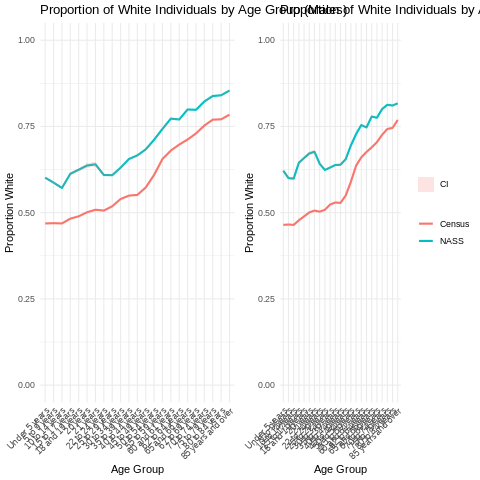

In [19]:
%%R

# Plot the trends for males
plot_males <- ggplot() +
  geom_line(data = nass_proportions %>% filter(GENDER == "Male"), aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1), linewidth = 1) +
  geom_ribbon(data = nass_proportions %>% filter(GENDER == "Male"), aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions %>% filter(gender == "Male"), aes(x = age_group, y = proportion_white, color = "Census", group = 1), linewidth = 1) +
  labs(title = "Proportion of White Individuals by Age Group (Males)",
       x = "Age Group",
       y = "Proportion White") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.title = element_blank(),
        legend.position = "none") +
  scale_y_continuous(limits = c(0, 1))

# Plot the trends for females
plot_females <- ggplot() +
  geom_line(data = nass_proportions %>% filter(GENDER == "Female"), aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1), linewidth = 1) +
  geom_ribbon(data = nass_proportions %>% filter(GENDER == "Female"), aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions %>% filter(gender == "Female"), aes(x = age_group, y = proportion_white, color = "Census", group = 1), linewidth = 1) +
  labs(title = "Proportion of White Individuals by Age Group (Females)",
       x = "Age Group",
       y = "Proportion White") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.title = element_blank(),
        legend.position = "right") +
  scale_y_continuous(limits = c(0, 1))

# Display the plots side by side
grid.arrange(plot_males, plot_females, ncol = 2)


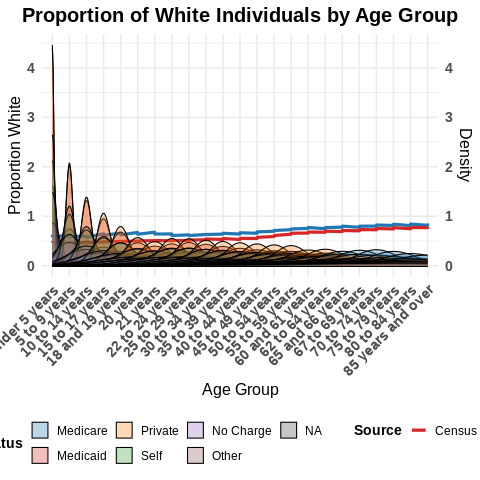

In [17]:
%%R

# Ensure PAY1 is treated as a factor with proper labels
NASS_2020_all <- NASS_2020_all %>%
  mutate(PAY1 = factor(PAY1, levels = c("1", "2", "3", "4", "5", "6"),
                       labels = c("Medicare", "Medicaid", "Private", "Self", "No Charge", "Other")))

# Revised plot with trend lines and distribution curves on the same x-axis
combined_plot <- ggplot() +
  # Trend lines for NASS and Census
  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1), linewidth = 1.5) +
  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1), linewidth = 1.5) +

  # Density curves for payor status
  geom_density(data = NASS_2020_all, aes(x = AGE_GROUP, fill = PAY1), alpha = 0.3, position = "identity") +

  # Labels and titles
  labs(
    title = "Proportion of White Individuals by Age Group",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  ) +

  # Theme adjustments for clarity and boldness
  theme_minimal(base_size = 16) +  # Increase base font size
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14, face = "bold"),  # Rotate and bold x-axis labels
    axis.text.y = element_text(size = 14, face = "bold"),  # Bold y-axis labels
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),  # Center and bold title
    legend.title = element_text(size = 14, face = "bold"),  # Bold legend title
    legend.text = element_text(size = 12),  # Increase legend text size
    legend.position = "bottom"  # Move legend to the bottom
  ) +

  # Scale adjustments for red, white, and blue theme
  scale_color_manual(values = c("NASS" = "#1f77b4", "Census" = "#d62728")) +  # Blue for NASS, Red for Census
  scale_fill_manual(values = c("Medicare" = "#1f77b4", "Medicaid" = "#d62728", "Private" = "#ff7f0e",
                                "Self" = "#2ca02c", "No Charge" = "#9467bd", "Other" = "#8c564b")) +  # Payor status colors
  scale_y_continuous(sec.axis = dup_axis(name = "Density"))  # Add secondary y-axis for density

# Display the plot
print(combined_plot)

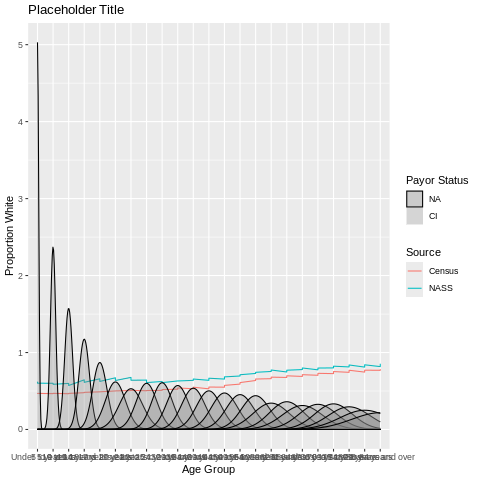

In [20]:
%%R

# Ensure PAY1 is treated as a factor with proper labels
NASS_2020_all <- NASS_2020_all %>%
  mutate(PAY1 = factor(PAY1, levels = c("1", "2", "3", "4", "5", "6"),
                       labels = c("Medicare", "Medicaid", "Private", "Self", "No Charge", "Other")))

# Simplified plot
combined_plot <- ggplot() +
  # Trend lines for NASS and Census
  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1)) +
  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1)) +

  # Density curves for payor status
  geom_density(data = NASS_2020_all, aes(x = AGE_GROUP, fill = PAY1), alpha = 0.3, position = "identity") +

  # Labels
  labs(
    title = "Placeholder Title",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  )

# Display the plot
print(combined_plot)


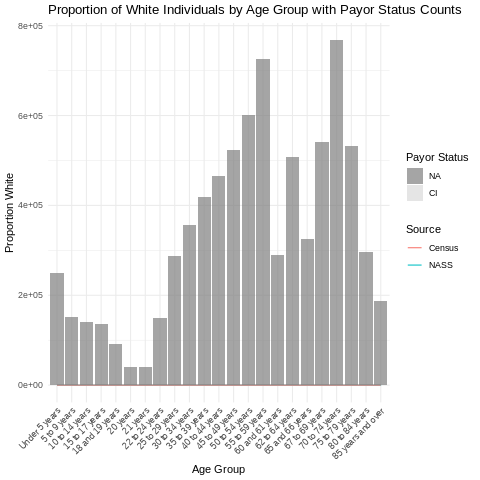

In [21]:
%%R

# Aggregate data to calculate counts for each AGE_GROUP and PAY1
frequency_data <- NASS_2020_all %>%
  group_by(AGE_GROUP, PAY1) %>%
  summarise(count = n(), .groups = "drop")  # Count the number of cases per group

# Ensure PAY1 is treated as a factor with proper labels
frequency_data <- frequency_data %>%
  mutate(PAY1 = factor(PAY1, levels = c("1", "2", "3", "4", "5", "6"),
                       labels = c("Medicare", "Medicaid", "Private", "Self", "No Charge", "Other")))

# Improved plot
combined_plot <- ggplot() +
  # Trend lines for NASS and Census
  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1)) +
  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1)) +

  # Bar plot for counts by payor status
  geom_bar(data = frequency_data, aes(x = AGE_GROUP, y = count, fill = PAY1), stat = "identity", position = "stack", alpha = 0.7) +

  # Labels
  labs(
    title = "Proportion of White Individuals by Age Group with Payor Status Counts",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  ) +

  # Rotate x-axis labels for readability
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Display the plot
print(combined_plot)


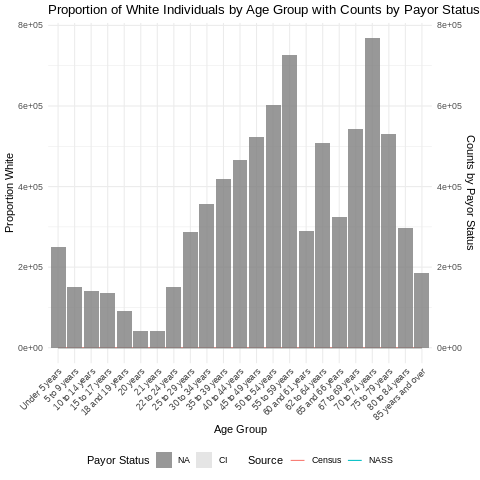

In [22]:
%%R

# Reclassify PAY1 into three buckets: Medicare, Medicaid, and Private/Other
NASS_2020_all <- NASS_2020_all %>%
  mutate(PAY1_grouped = case_when(
    PAY1 == "1" ~ "Medicare",
    PAY1 == "2" ~ "Medicaid",
    PAY1 %in% c("3", "4", "5", "6") ~ "Private/Other"
  ))

# Aggregate data to calculate counts for each AGE_GROUP and PAY1_grouped
bar_data <- NASS_2020_all %>%
  group_by(AGE_GROUP, PAY1_grouped) %>%
  summarise(count = n(), .groups = "drop")  # Count the number of cases per group

# Ensure PAY1_grouped is treated as a factor with proper order
bar_data <- bar_data %>%
  mutate(PAY1_grouped = factor(PAY1_grouped, levels = c("Medicare", "Medicaid", "Private/Other")))

# Create the combined plot
combined_plot <- ggplot() +
  # Line graphs for NASS and Census
  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1)) +
  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1)) +

  # Bar graph for counts by PAY1_grouped
  geom_bar(data = bar_data, aes(x = AGE_GROUP, y = count, fill = PAY1_grouped),
           stat = "identity", position = position_dodge(width = 0.8), alpha = 0.8) +

  # Labels
  labs(
    title = "Proportion of White Individuals by Age Group with Counts by Payor Status",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  ) +

  # Scale adjustments
  scale_y_continuous(
    name = "Proportion White",
    sec.axis = sec_axis(~., name = "Counts by Payor Status")  # Secondary y-axis for bar graph
  ) +

  # Theme adjustments for clarity
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels for readability
    legend.position = "bottom"  # Place legend at the bottom
  )

# Display the plot
print(combined_plot)

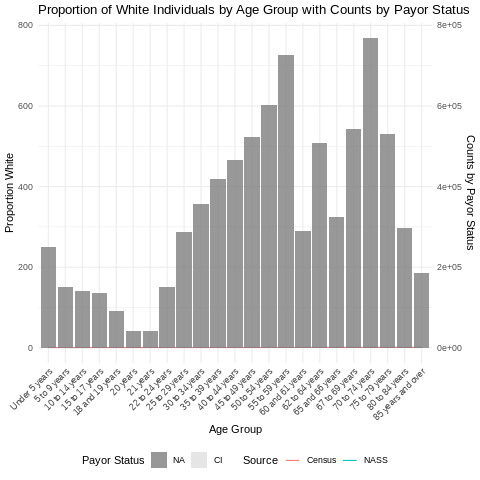

In [23]:
%%R

# Reclassify PAY1 into three buckets: Medicare, Medicaid, and Private/Other
NASS_2020_all <- NASS_2020_all %>%
  mutate(PAY1_grouped = case_when(
    PAY1 == "Medicare" ~ "Medicare",
    PAY1 == "Medicaid" ~ "Medicaid",
    PAY1 %in% c("Private", "Self", "No Charge", "Other") ~ "Private/Other"
  ))

# Aggregate data to calculate counts for each AGE_GROUP and PAY1_grouped
bar_data <- NASS_2020_all %>%
  group_by(AGE_GROUP, PAY1_grouped) %>%
  summarise(count = n(), .groups = "drop")  # Count the number of cases per group

# Ensure PAY1_grouped is treated as a factor with proper order
bar_data <- bar_data %>%
  mutate(PAY1_grouped = factor(PAY1_grouped, levels = c("Medicare", "Medicaid", "Private/Other")))

# Create the combined plot
combined_plot <- ggplot() +
  # Line graphs for NASS and Census
  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1)) +
  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1)) +

  # Bar graph for counts by PAY1_grouped
  geom_bar(data = bar_data, aes(x = AGE_GROUP, y = count / 1000, fill = PAY1_grouped),  # Scale counts for secondary axis
           stat = "identity", position = position_dodge(width = 0.8), alpha = 0.8) +

  # Labels
  labs(
    title = "Proportion of White Individuals by Age Group with Counts by Payor Status",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  ) +

  # Scale adjustments
  scale_y_continuous(
    name = "Proportion White",
    sec.axis = sec_axis(~ . * 1000, name = "Counts by Payor Status")  # Secondary y-axis for bar graph
  ) +

  # Theme adjustments for clarity
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels for readability
    legend.position = "bottom"  # Place legend at the bottom
  )

# Display the plot
print(combined_plot)

In [25]:
%%R

summary(bar_data)

           AGE_GROUP         PAY1_grouped     count       
 Under 5 years  : 1   Medicare     : 0    Min.   : 41189  
 5 to 9 years   : 1   Medicaid     : 0    1st Qu.:150871  
 10 to 14 years : 1   Private/Other: 0    Median :296092  
 15 to 17 years : 1   NA's         :23    Mean   :340361  
 18 and 19 years: 1                       3rd Qu.:515356  
 20 years       : 1                       Max.   :767685  
 (Other)        :17                                       


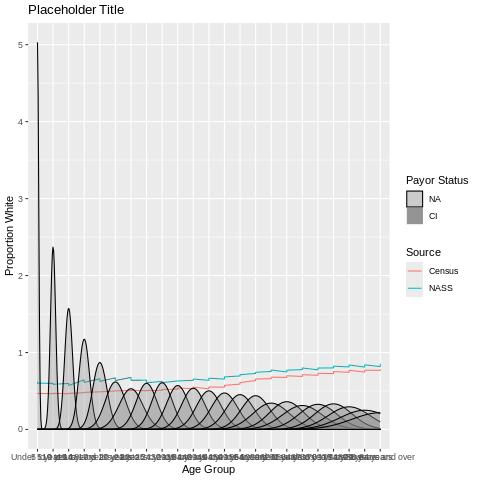

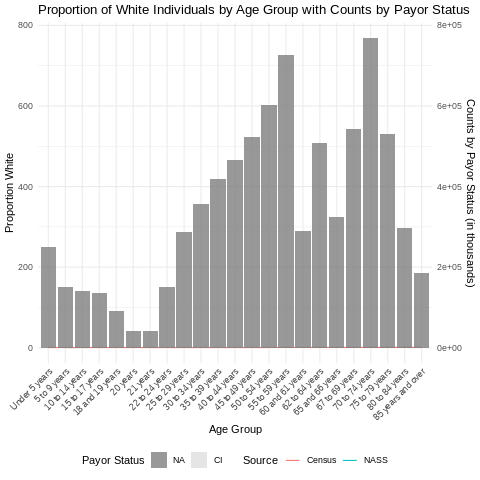

In [27]:
%%R

# Define payor labels and group them into three buckets
pay_labels <- c("1" = "Medicare", "2" = "Medicaid", "3" = "Private", "4" = "Self", "5" = "No Charge", "6" = "Other")
NASS_2020_all <- NASS_2020_all %>%
  mutate(PAY1 = factor(PAY1, levels = names(pay_labels), labels = pay_labels),
         PAY1_grouped = case_when(
           PAY1 == "Medicare" ~ "Medicare",
           PAY1 == "Medicaid" ~ "Medicaid",
           PAY1 %in% c("Private", "Self", "No Charge", "Other") ~ "Private/Other"
         ))

# Aggregate data to calculate counts for each AGE_GROUP and PAY1_grouped
bar_data <- NASS_2020_all %>%
  group_by(AGE_GROUP, PAY1_grouped) %>%
  summarise(count = n(), .groups = "drop")  # Count the number of cases per group

# Ensure PAY1_grouped is treated as a factor with proper order
bar_data <- bar_data %>%
  mutate(PAY1_grouped = factor(PAY1_grouped, levels = c("Medicare", "Medicaid", "Private/Other")))

# Create the combined plot
combined_plot <- ggplot() +
  # Line graphs for NASS and Census
  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1)) +
  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1)) +

  # Bar graph for counts by PAY1_grouped
  geom_bar(data = bar_data, aes(x = AGE_GROUP, y = count / 1000, fill = PAY1_grouped),  # Scale counts for secondary axis
           stat = "identity", position = position_dodge(width = 0.8), alpha = 0.8) +

  # Labels
  labs(
    title = "Proportion of White Individuals by Age Group with Counts by Payor Status",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  ) +

  # Scale adjustments
  scale_y_continuous(
    name = "Proportion White",
    sec.axis = sec_axis(~ . * 1000, name = "Counts by Payor Status (in thousands)")  # Secondary y-axis for bar graph
  ) +

  # Theme adjustments for clarity
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels for readability
    legend.position = "bottom"  # Place legend at the bottom
  )

# Display the plot
print(combined_plot)

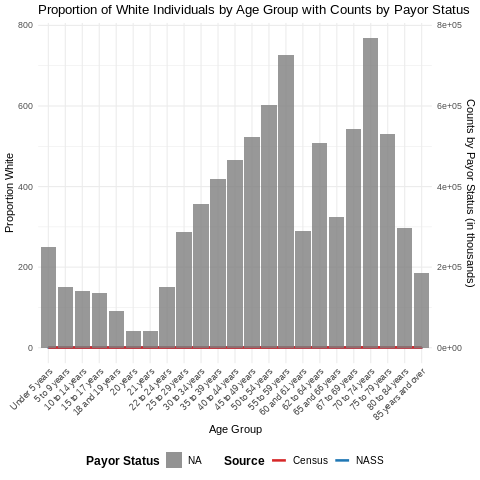

In [30]:
%%R

# Define payor labels and group them into three buckets
pay_labels <- c("1" = "Medicare", "2" = "Medicaid", "3" = "Private", "4" = "Self", "5" = "No Charge", "6" = "Other")
NASS_2020_all <- NASS_2020_all %>%
  mutate(PAY1 = factor(PAY1, levels = names(pay_labels), labels = pay_labels),
         PAY1_grouped = case_when(
           PAY1 == "Medicare" ~ "Medicare",
           PAY1 == "Medicaid" ~ "Medicaid",
           PAY1 %in% c("Private", "Self", "No Charge", "Other") ~ "Private/Other"
         ))

# Aggregate data to calculate counts for each AGE_GROUP and PAY1_grouped
bar_data <- NASS_2020_all %>%
  group_by(AGE_GROUP, PAY1_grouped) %>%
  summarise(count = n(), .groups = "drop")  # Count the number of cases per group

# Ensure PAY1_grouped is treated as a factor with proper order
bar_data <- bar_data %>%
  mutate(PAY1_grouped = factor(PAY1_grouped, levels = c("Medicare", "Medicaid", "Private/Other")))

# Create the combined plot
combined_plot <- ggplot() +
  # Line graphs for NASS and Census
  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1), linewidth = 1.2) +
  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1), linewidth = 1.2) +

  # Bar graph for counts by PAY1_grouped
  geom_bar(data = bar_data, aes(x = AGE_GROUP, y = count / 1000, fill = PAY1_grouped),  # Scale counts for secondary axis
           stat = "identity", position = position_dodge(width = 0.8), alpha = 0.8) +

  # Labels
  labs(
    title = "Proportion of White Individuals by Age Group with Counts by Payor Status",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  ) +

  # Scale adjustments
  scale_y_continuous(
    name = "Proportion White",
    sec.axis = sec_axis(~ . * 1000, name = "Counts by Payor Status (in thousands)")  # Secondary y-axis for bar graph
  ) +

  # Theme adjustments for clarity
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels for readability
    legend.position = "bottom",  # Place legend at the bottom
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10)
  ) +

  # Color adjustments for clarity
  scale_color_manual(values = c("NASS" = "#1f77b4", "Census" = "#d62728")) +  # Blue for NASS, Red for Census
  scale_fill_manual(values = c("Medicare" = "#1f77b4", "Medicaid" = "#ff7f0e", "Private/Other" = "#2ca02c"))  # Distinct colors for payor buckets

# Display the plot
print(combined_plot)

In [27]:
%%R

age_breaks <- c(-Inf, 4, 9, 14, 17, 19, 20, 21, 24, 29, 34, 39, 44, 49, 54, 59, 61, 64, 66, 69, 74, 79, 84, Inf)
age_labels <- c("Under 5 years", "5 to 9 years", "10 to 14 years", "15 to 17 years", "18 and 19 years",
                "20 years", "21 years", "22 to 24 years", "25 to 29 years", "30 to 34 years",
                "35 to 39 years", "40 to 44 years", "45 to 49 years", "50 to 54 years", "55 to 59 years",
                "60 and 61 years", "62 to 64 years", "65 and 66 years", "67 to 69 years", "70 to 74 years",
                "75 to 79 years", "80 to 84 years", "85 years and over")

# Create age group variable in NASS dataset
NASS_2020_some <- NASS_2020_all[, c(1:28, 108, 674)]
NASS_2020_some <- NASS_2020_all %>%
  mutate(AGE_GROUP = cut(AGE, breaks = age_breaks, labels = age_labels, right = TRUE))
summary(NASS_2020_some$PAY1)
gc()

             used    (Mb) gc trigger  (Mb)   max used  (Mb)
Ncells    2887789   154.3    4267914   228    4267914   228
Vcells 2791846403 21300.1 4355117177 33227 4354601507 33223


In [35]:
%%R

# Define payor labels and group them into three buckets
pay_labels <- c("1" = "Medicare", "2" = "Medicaid", "3" = "Private", "4" = "Self", "5" = "No Charge", "6" = "Other")
# Create the PAY1_grouped column directly without modifying PAY1
NASS_2020_some <- NASS_2020_some %>%
  mutate(PAY1_grouped = case_when(
    PAY1 %in% c("Medicare") ~ "Medicare",
    PAY1 %in% c("Medicaid") ~ "Medicaid",
    PAY1 %in% c("Private", "Self", "No Charge", "Other") ~ "Private/Other",
    TRUE ~ NA_character_  # Handle unexpected values
  ))

# Aggregate data to calculate counts for each AGE_GROUP and PAY1_grouped
bar_data <- NASS_2020_some %>%
  group_by(AGE_GROUP, PAY1_grouped) %>%
  summarise(count = n(), .groups = "drop")  # Count the number of cases per group

# Ensure PAY1_grouped is treated as a factor with proper order
bar_data <- bar_data %>%
  mutate(PAY1_grouped = factor(PAY1_grouped, levels = c("Medicare", "Medicaid", "Private/Other")))

head(bar_data)

# A tibble: 6 × 3
  AGE_GROUP     PAY1_grouped   count
  <fct>         <fct>          <int>
1 Under 5 years Medicaid      110454
2 Under 5 years Medicare         655
3 Under 5 years Private/Other 137833
4 Under 5 years <NA>             444
5 5 to 9 years  Medicaid       68580
6 5 to 9 years  Medicare         430


In [29]:
%%R

summary(NASS_2020_some$PAY1)


 Medicare  Medicaid   Private      Self No Charge     Other      NA's 
  2601624   1019170   3640228    220234     10996    326171      9887 


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


In addition: Warning message:
No shared levels found between `names(values)` of the manual scale and the
data's colour values. 


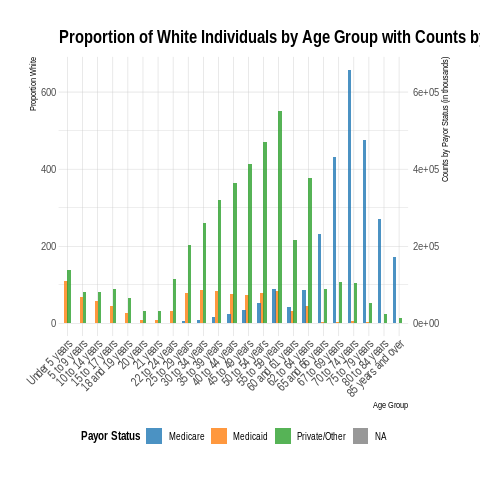

In [41]:
%%R
# Install and load the hrbrthemes package
if (!require("hrbrthemes")) install.packages("hrbrthemes")
library(hrbrthemes)

# Create the PAY1_grouped column directly without modifying PAY1
NASS_2020_some <- NASS_2020_some %>%
  mutate(PAY1_grouped = case_when(
    PAY1 %in% c("1") ~ "Medicare",
    PAY1 %in% c("2") ~ "Medicaid",
    PAY1 %in% c("3", "4", "5", "6") ~ "Private/Other",
    TRUE ~ NA_character_  # Handle unexpected values
  ))

# Create dummy data for the line
dummy_data <- data.frame(
  AGE_GROUP = unique(NASS_2020_some$AGE_GROUP),  # Use unique AGE_GROUP values
  dummy_proportion = seq(0.5, 0.8, length.out = length(unique(NASS_2020_some$AGE_GROUP)))  # Generate values from 0.5 to 0.8
)

# Create the combined plot
combined_plot <- ggplot() +
  # Line graphs for NASS and Census
#  geom_line(data = nass_proportions, aes(x = AGE_GROUP, y = proportion_white, color = "NASS", group = 1), linewidth = 1.2) +
#  geom_ribbon(data = nass_proportions, aes(x = AGE_GROUP, ymin = ci_lower, ymax = ci_upper, fill = "CI", group = 1), alpha = 0.2) +
#  geom_line(data = census_proportions, aes(x = age_group, y = proportion_white, color = "Census", group = 1), linewidth = 1.2) +

  # Dummy line
  geom_line(data = dummy_data, aes(x = AGE_GROUP, y = dummy_proportion), color = "purple", linetype = "dashed", linewidth = 1) +



  # Bar graph for counts by PAY1_grouped
  geom_bar(data = bar_data, aes(x = AGE_GROUP, y = count / 1000, fill = PAY1_grouped),  # Scale counts for secondary axis
           stat = "identity", position = position_dodge(width = 0.8), alpha = 0.8) +

  # Labels
  labs(
    title = "Proportion of White Individuals by Age Group with Counts by Payor Status",
    x = "Age Group",
    y = "Proportion White",
    fill = "Payor Status",
    color = "Source"
  ) +

  # Scale adjustments
  scale_y_continuous(
    name = "Proportion White",
    sec.axis = sec_axis(~ . * 1000, name = "Counts by Payor Status (in thousands)")  # Secondary y-axis for bar graph
  ) +

  # Theme adjustments for clarity
  theme_ipsum() + # Now theme_ipsum() should work
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels for readability
    legend.position = "bottom",  # Place legend at the bottom
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10)
  ) +

  # Color adjustments for clarity
  scale_color_manual(values = c("NASS" = "#1f77b4", "Census" = "#d62728")) +  # Blue for NASS, Red for Census
  scale_fill_manual(values = c("Medicare" = "#1f77b4", "Medicaid" = "#ff7f0e", "Private/Other" = "#2ca02c"))  # Distinct colors for payor buckets

# Display the plot
print(combined_plot)

# Procedure Code Analysis

In [16]:
%%R

# Define payor labels and group them into three buckets
pay_labels <- c("1" = "Medicare", "2" = "Medicaid", "3" = "Private", "4" = "Self", "5" = "No Charge", "6" = "Other")
NASS_2020_all <- NASS_2020_all %>%
  mutate(PAY1 = factor(PAY1, levels = names(pay_labels), labels = pay_labels),
         PAY1_grouped = case_when(
           PAY1 == "Medicare" ~ "Medicare",
           PAY1 == "Medicaid" ~ "Medicaid",
           PAY1 %in% c("Private", "Self", "No Charge", "Other") ~ "Private/Other",
           TRUE ~ NA_character_  # Handle unexpected values
         ))

# Aggregate data to calculate counts for each AGE_GROUP and PAY1_grouped
bar_data <- NASS_2020_all %>%
  group_by(AGE_GROUP, PAY1_grouped) %>%
  summarise(count = n(), .groups = "drop")  # Count the number of cases per group

# Ensure PAY1_grouped is treated as a factor with proper order
bar_data <- bar_data %>%
  mutate(PAY1_grouped = factor(PAY1_grouped, levels = c("Medicare", "Medicaid", "Private/Other")))

Error in `group_by()`:
! Must group by variables found in `.data`.
✖ Column `AGE_GROUP` is not found.
Run `rlang::last_trace()` to see where the error occurred.

Error in group_by(., AGE_GROUP, PAY1_grouped) : 
✖ Column `AGE_GROUP` is not found.


RInterpreterError: Failed to parse and evaluate line '\n# Define payor labels and group them into three buckets\npay_labels <- c("1" = "Medicare", "2" = "Medicaid", "3" = "Private", "4" = "Self", "5" = "No Charge", "6" = "Other")\nNASS_2020_all <- NASS_2020_all %>%\n  mutate(PAY1 = factor(PAY1, levels = names(pay_labels), labels = pay_labels),\n         PAY1_grouped = case_when(\n           PAY1 == "Medicare" ~ "Medicare",\n           PAY1 == "Medicaid" ~ "Medicaid",\n           PAY1 %in% c("Private", "Self", "No Charge", "Other") ~ "Private/Other",\n           TRUE ~ NA_character_  # Handle unexpected values\n         ))\n\n# Aggregate data to calculate counts for each AGE_GROUP and PAY1_grouped\nbar_data <- NASS_2020_all %>%\n  group_by(AGE_GROUP, PAY1_grouped) %>%\n  summarise(count = n(), .groups = "drop")  # Count the number of cases per group\n\n# Ensure PAY1_grouped is treated as a factor with proper order\nbar_data <- bar_data %>%\n  mutate(PAY1_grouped = factor(PAY1_grouped, levels = c("Medicare", "Medicaid", "Private/Other")))\n'.
R error message: 'Error in group_by(., AGE_GROUP, PAY1_grouped) : \n✖ Column `AGE_GROUP` is not found.'

# ML Race Classifier Analysis

# ML Rural-Urban Classifier Analysis

# Appendix A: Time Series of 2020 Volumes

# Appendix B: Age Progression of Surgical Cases

# Appendix C: Indexing of Case Variety and Patient Diversity vs. Government Payment Mix

# Academic Poster Output